# Weather prediction - time series
- Climate dataset from [Max Planck Institute](https://www.bgc-jena.mpg.de/wetter/)
- Baseline from [keras](https://keras.io/examples/timeseries/timeseries_weather_forecasting/)
- [Open in Colab](https://colab.research.google.com/drive/15jaSG9xdD02dSPKs74LuQ-zmc68pV6-I)

In [ ]:
!pip install -U tfts --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tfts import AutoConfig, AutoModel, KerasTrainer

## EDA

In [3]:
from zipfile import ZipFile

uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = tf.keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)

df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


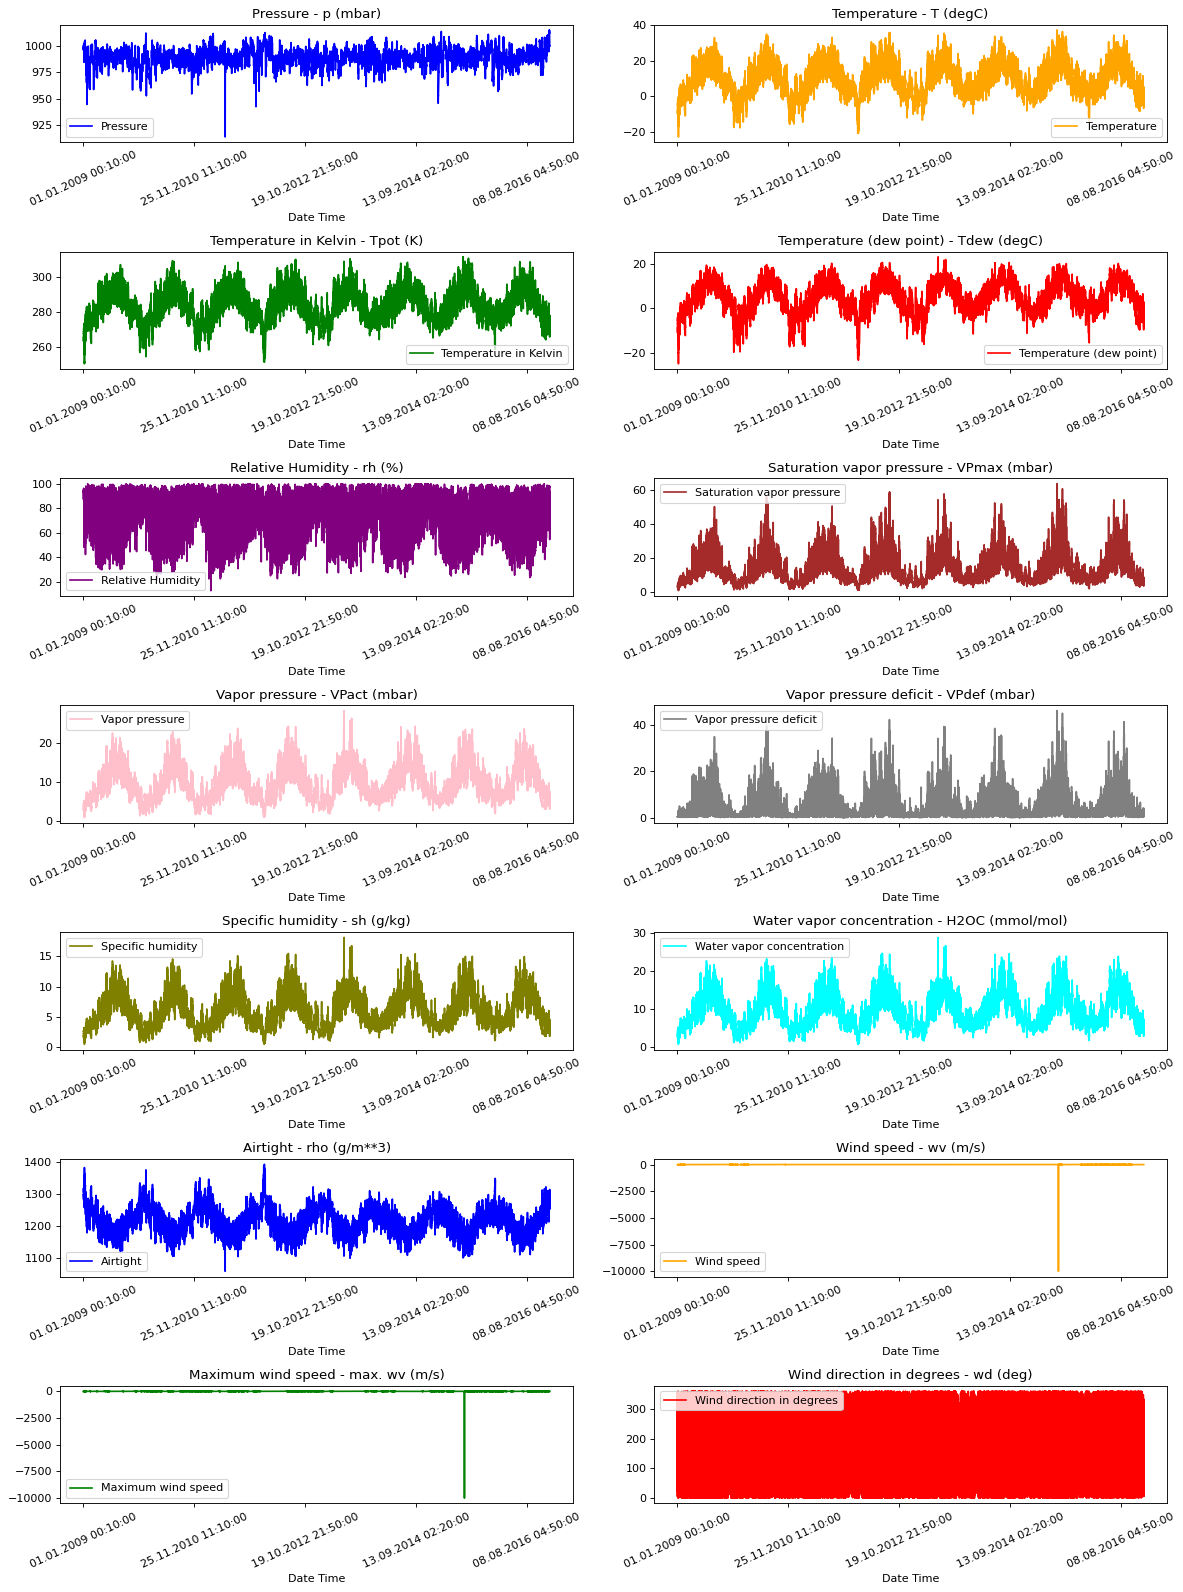

In [ ]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k")
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title=f"{titles[i]} - {key}",
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

## Data preparation

In [5]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 6

past = 720
future = 72
learning_rate = 0.001
batch_size = 256
epochs = 10


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std


print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df[selected_features]
features.index = df[date_time_key]
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

start = past + future
end = start + train_split

x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)


dataset_train = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


# valid
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

The selected parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed
Input shape: (256, 120, 7)
Target shape: (256, 1)


## Training

In [6]:
model_name_or_path = "rnn"
config = AutoConfig.for_model(model_name_or_path)
config.rnn_type = "lstm"
print(config)

model = AutoModel.from_config(config, predict_sequence_length=1)

{'rnn_hidden_size': 64, 'rnn_type': 'lstm', 'bi_direction': False, 'dense_hidden_size': 32, 'num_stacked_layers': 1, 'scheduled_sampling': 0, 'use_attention': False}


In [7]:
%%time
opt = tf.keras.optimizers.Adam(learning_rate)
loss_fn = tf.keras.losses.MeanSquaredError()
trainer = KerasTrainer(model, loss_fn=loss_fn, optimizer=opt)

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

history = trainer.train(
    dataset_train, dataset_val, epochs=epochs, batch_size=batch_size, callbacks=[early_stop_callback]
)

Epoch 1/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 159s 133ms/step - loss: 0.3661 - val_loss: 0.2449
Epoch 2/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 150s 128ms/step - loss: 0.2009 - val_loss: 0.2461
Epoch 3/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 146s 125ms/step - loss: 0.1796 - val_loss: 0.2341
Epoch 4/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 147s 126ms/step - loss: 0.1698 - val_loss: 0.2358
Epoch 5/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 146s 124ms/step - loss: 0.1581 - val_loss: 0.2414
Epoch 6/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 148s 126ms/step - loss: 0.1528 - val_loss: 0.2255
Epoch 7/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 147s 125ms/step - loss: 0.1477 - val_loss: 0.2380
Epoch 8/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 144s 123ms/step - loss: 0.1421 - val_loss: 0.2291
Epoch 9/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 148s 126ms/step - loss: 0.1400 - val_loss: 0.2319
Epoch 10/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 149s 127ms/step - loss: 0.1397 - val_loss: 0.2289


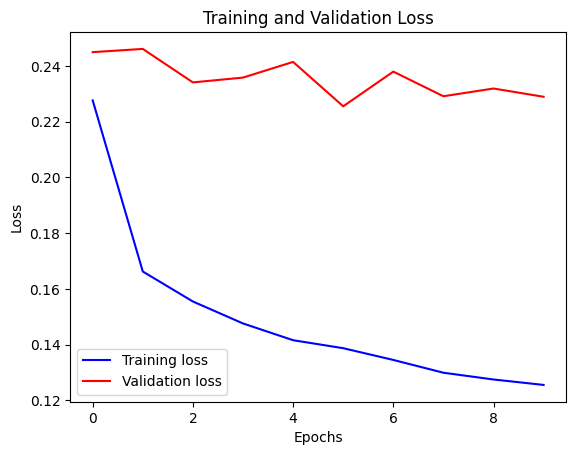

In [8]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

## Evaluation

## Testing

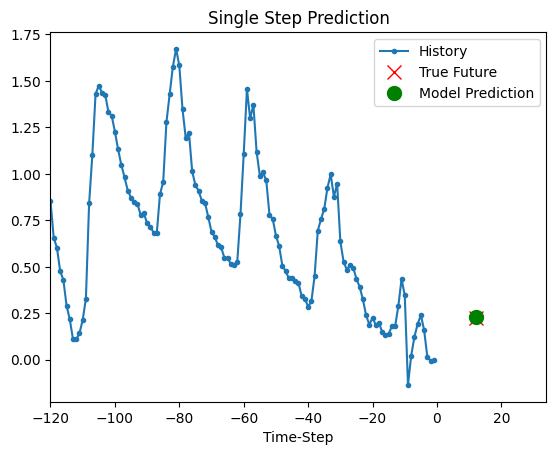

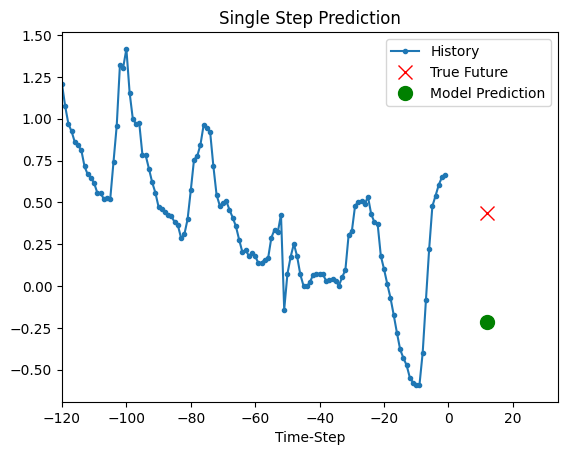

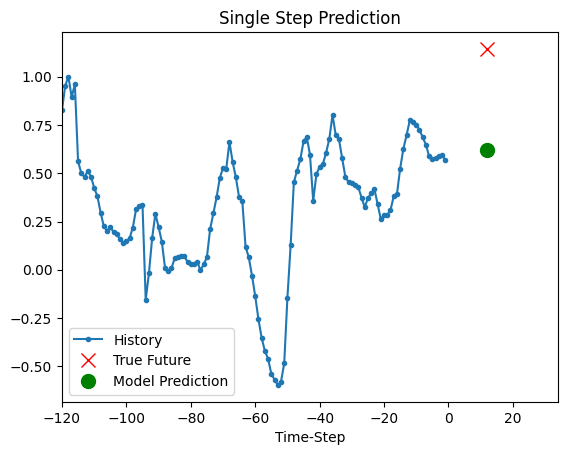

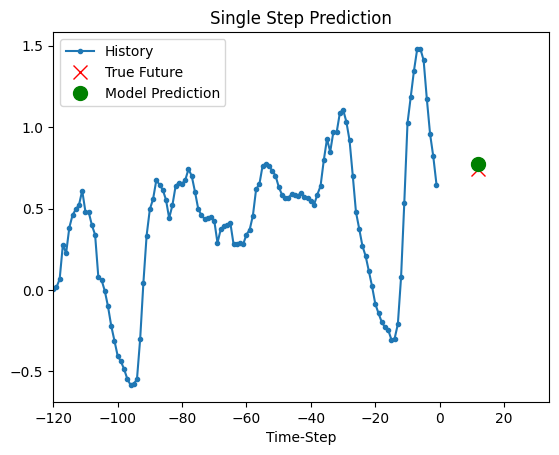

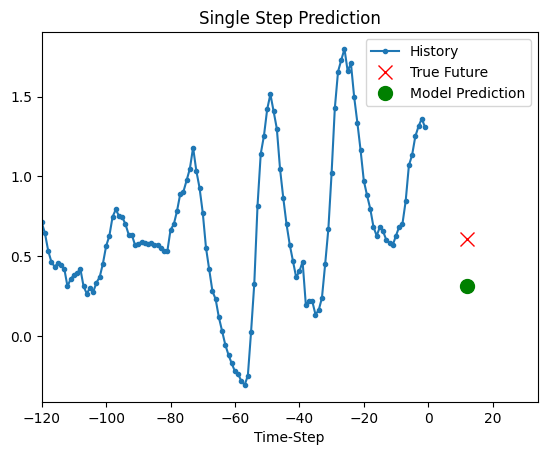

In [10]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model(x)[0]],
        12,
        "Single Step Prediction",
    )